In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [ ]:
# Hyperparameters
numOfConvLayers = 4
numOfKernels = 12
numOfNeurons = 12
learningRate = 0.1
batchSize = 48
numOfEpochs = 50
kernelSize = 3
activation = F.relu       
optimizer_func = torch.optim.SGD
loss_fnc = nn.CrossEntropyLoss()
batchNorm = False
numOfFCLayers = 2
testSize = 0.2
valSize = 0.2
seed = 42

In [41]:
# Helpers
def plot_full_data(trainAccuracies, trainLosses, validAccuracies, validLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='training')
  pyplot.plot(validAccuracies, label='validation')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of the full dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='traning')
  pyplot.plot(validLosses, label='validation')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of the full dataset')
  pyplot.show()

# Train Overfit Model
def overfit_training (data_loader, model, optimizer):
  trainAccuracies = []
  trainLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalLoss = 0
    totalCorrect = 0
    for i, (inputs, labels) in enumerate(data_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels)  
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()
    
      del outputs
      del loss
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_accuracy = float(totalCorrect) / len(data_loader.dataset) 
    avg_loss = totalLoss/len(data_loader)
    print(epoch, avg_loss, avg_accuracy)
    trainAccuracies += [avg_accuracy]  
    trainLosses += [avg_loss]
  print("total time: ")
  print(time.time()-start_time)
  return trainAccuracies, trainLosses

def numOfCorrectPredictions(Y, L):
  result = Y.argmax(1)      # Get the maximum value in each output and compare it to its label
  return (result == L).sum()

def evaluate(model, data_loader, batchNorm):   # used on validation and test set
  total_corr = 0
  totalLoss = 0
  if batchNorm:
    model.eval()
  else:
    model.train()
  for i, (inputs, labels) in enumerate(data_loader):
    oneh_labels = oneh_classes[labels]
    outputs = model(inputs)
    if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
      loss = loss_fnc(input=outputs, target=labels) 
    else: 
      loss = loss_fnc(input=outputs, target=oneh_labels) 
    total_corr += numOfCorrectPredictions(outputs, labels) 
    totalLoss += loss.item()
  accuracy = float(total_corr)/len(data_loader.dataset)
  loss = totalLoss/len(data_loader)
  return (loss, accuracy)

In [5]:
# Custom Pad Pipeline
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

In [16]:
# Input overfit, train, val, test dataset 
# Load un-normalized data to compute mean and standard deviation.
image_size = (100, 130) # size of biggest image (100 height is standard already)
crop_image_size = (100, 65) # size of the smallest image (100 height is standard already)

data_pipe = transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

path = 'data'
overfit_path = 'data'
dataset_raw = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipe)
loader = DataLoader(dataset_raw, batch_size=len(dataset_raw))
data = next(iter(loader))
mean = torch.mean(data[0], (0,2,3))
std = torch.std(data[0], (0,2,3))
overfit_raw = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=data_pipe)
loader = DataLoader(overfit_raw, batch_size=len(overfit_raw))
data = next(iter(loader))
mean_overfit = torch.mean(data[0], (0,2,3))
std_overfit = torch.std(data[0], (0,2,3))

# Define pad pipeline
data_pipeline_normal_reg = transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
data_pipeline_normal_over = transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_overfit, std_overfit)
])

# Normalized dataset
dataset = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipeline_normal_reg)
overfit_set = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=data_pipeline_normal_over)


overfit_loader = DataLoader(overfit_set, batch_size=batchSize, shuffle=True)

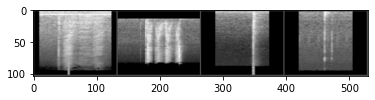

Circle Scratch W Scratch Fingernail Tap Fingertip Tap
The one-hot classes are: 
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [22]:
# Check the ground truth of the images
def imshow(img):
  img[0] = img[0] * std[0] + mean[0]     # De-normalize
  img[1] = img[1] * std[1] + mean[1]     # De-normalize
  img[2] = img[2] * std[2] + mean[2]     # De-normalize
  npimg = img.numpy()
  pyplot.imshow(np.transpose(npimg, (1, 2, 0)))
  pyplot.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:4]))
classes = ['Circle Scratch', 'Fingernail Tap', 'Fingertip Tap', 'Silence', 'Vertical Scratch', 'W Scratch'] 
print(' '.join('%5s' % classes[labels[j]] for j in range(0,4))) 

# One-hot encode the classes
oneh_encoder = OneHotEncoder()
oneh_classes = torch.Tensor(oneh_encoder.fit_transform(np.asarray(classes).reshape(-1, 1)).toarray())
print("The one-hot classes are: ")
print (oneh_classes)

In [71]:
class CNN(nn.Module):
  def __init__(self, input_dims, numOfKernels, numOfNeurons, kernelSize, numOfConvLayers, batchNorm):
    super(CNN, self).__init__()         
    self.numOfKernels = numOfKernels
    self.batchNorm = batchNorm
    self.numOfConvLayers = numOfConvLayers

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3,numOfKernels, kernelSize)
    self.conv2 = nn.Conv2d(numOfKernels,numOfKernels, kernelSize)
    self.conv_BN = nn.BatchNorm2d(numOfKernels)

    # Determine the output size after the convolutional layer
    fullLayerSize_x = input_dims[1]
    fullLayerSize_y = input_dims[0]
    for i in range (self.numOfConvLayers):
      fullLayerSize_x = (fullLayerSize_x-kernelSize+1)//2
      fullLayerSize_y = (fullLayerSize_y-kernelSize+1)//2

    # Fully connected layers
    self.fc1 = nn.Linear(numOfKernels*fullLayerSize_x*fullLayerSize_y, numOfNeurons)
    self.fc1_BN = nn.BatchNorm1d(numOfNeurons)
    self.pool = nn.MaxPool2d(2,2)
    self.fc2 = nn.Linear(numOfNeurons, 6)
    self.fc2_BN = nn.BatchNorm1d(6)

  def forward(self, x):
    if self.batchNorm == True:
      x = self.pool(activation(self.conv_BN(self.conv1(x))))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv_BN(self.conv2(x))))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1_BN(self.fc1(x)))
      x = self.fc2_BN(self.fc2(x))
    else: 
      x = self.pool(activation(self.conv1(x)))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv2(x)))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1(x))
      x = self.fc2(x)
    return x

In [72]:
SEED = [6, 42]
BATCH_SIZE = [24, 48, 64]
NUM_NEURONS = 100
NUM_KERNELS = [4, 8, 12]
LEARNING = [0.1, 0.01]
EPOCHS = 50

hunts = [[sd, bt, nk, lr] for sd in SEED
                          for bt in BATCH_SIZE
                          for nk in NUM_KERNELS
                          for lr in LEARNING]

for hunt in hunts:
    TR_seed = hunt[0]
    TR_batch = hunt[1]
    TR_kernels = hunt[2]
    TR_LR = hunt[3]

    # create train, val, test, and overfit dataset
    train_set, test_set = train_test_split(dataset, test_size=testSize, random_state=TR_seed)   # split test
    train_set, val_set = train_test_split(train_set, test_size=valSize/(1-testSize), random_state=TR_seed)   # split train to train and val

    train_loader = DataLoader(train_set, batch_size=TR_batch, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=TR_batch, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=TR_batch, shuffle=True)

    # Training Loop
    def training(train_loader, val_loader, test_loader, model, optimizer):
        trainAccuracies = []
        validAccuracies = []
        trainLosses = []
        validLosses = []
        start_time = time.time()
        model.train()
        for epoch in range(EPOCHS):
            totalCorrect = 0
            totalLoss = 0
            for i, (inputs, labels) in enumerate(train_loader):
                optimizer.zero_grad() 
                outputs = model(inputs)                                  # Get outputs
                oneh_labels = oneh_classes[labels]                       # Get one hot labels
                if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
                    loss = loss_fnc(input=outputs, target=labels) 
                else: 
                    loss = loss_fnc(input=outputs, target=oneh_labels) 
                loss.backward()                                          # Compute loss gradients
                optimizer.step()                                         # Adjust weights 
                totalCorrect += numOfCorrectPredictions(outputs, labels)
                totalLoss += loss.item()

            # For every epoch, compute the training accuracy and loss
            # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
            # my loss at each epoch is the average loss over the entire epoch
            avg_train_accuracy = float(totalCorrect) / len(train_loader.dataset)
            avg_train_loss = totalLoss/len(train_loader)

            # For every epoch, get accuracy, and loss of the validation data
            (valid_loss, valid_accuracy) = evaluate(model, val_loader, batchNorm)
            trainAccuracies += [avg_train_accuracy]  
            trainLosses += [avg_train_loss]
            validAccuracies += [valid_accuracy]  
            validLosses += [valid_loss]

        print("total time: ")     # print total time 
        print(time.time()-start_time)
        (test_loss, test_accuracy) = evaluate(model, test_loader, batchNorm)    # evaluate the test data
        print("the test accuracy and loss after CNN model is ", test_accuracy, test_loss)

        return trainAccuracies, trainLosses, validAccuracies, validLosses, test_accuracy, test_loss

    torch.manual_seed(TR_seed)
    model = CNN(input_dims=(100, 130), numOfKernels=TR_kernels, numOfNeurons=NUM_NEURONS, kernelSize=3, numOfConvLayers=2, batchNorm=True)    # Load model 
    optimizer = optimizer_func(model.parameters(), lr=TR_LR)
    trainacc, trainloss, valacc, valloss, testacc, testloss = training(train_loader, val_loader, test_loader, model, optimizer)
    writeStr = '{}:{}:{}:{} => {}, {}, {}, {}, {}, {}'.format(TR_seed, TR_LR, TR_batch, TR_kernels, trainloss[-1], trainacc[-1], valloss[-1], valacc[-1], testloss, testacc)
    fl = open('log_padded.txt', 'a')
    fl.write(writeStr)
    fl.close()

    print(writeStr)

31 23


NameError: name 'fullLayerSize' is not defined